<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#get-clean-text" data-toc-modified-id="get-clean-text-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>get clean text</a></span><ul class="toc-item"><li><span><a href="#find-same-texts" data-toc-modified-id="find-same-texts-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>find same texts</a></span></li></ul></li><li><span><a href="#learn-fasttext-representations" data-toc-modified-id="learn-fasttext-representations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>learn fasttext representations</a></span></li><li><span><a href="#to-vectors" data-toc-modified-id="to-vectors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>to vectors</a></span></li></ul></div>

In [1]:
import re, os
from collections import Counter
import numpy as np
import pandas as pd
from gensim.models.fasttext import FastText
from keras.preprocessing.text import text_to_word_sequence
import functools

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# load data

In [2]:
path_data = os.path.join('..', 'data')
df = pd.read_csv(os.path.join(path_data, 'train', 'news_train.csv'))
data_type = 'news'# 'chat'
df['publication_date'] = pd.to_datetime(df['publication_date']).apply(lambda x: x.timestamp())
df['date'] = pd.to_datetime(df['date']).apply(lambda x: x.timestamp())
# pd.Series(pd.to_datetime(np.array(df_y_train.index))).apply(lambda x: x.timestamp())

df.head()

,link,title,publication_date,content,date,site,section
0,https://www.reddit.com/r/altcoin/comments/8a0e...,Bitcoin foundation co-founder upturns bitcoin ...,1.522940e+09,Bitcoin foundation co-founder upturns bitcoin ...,1.524049e+09,www.reddit.com,altcoin
1,https://www.reddit.com/r/crypto/comments/815zz...,A PoC versioning system based on IPFS and Arag...,1.519918e+09,A PoC versioning system based on IPFS and Arag...,1.524049e+09,www.reddit.com,crypto
2,https://www.reddit.com/r/datasets/comments/84x...,Fun Datasets to work with,1.521223e+09,Fun Datasets to work with,1.524049e+09,www.reddit.com,datasets
3,https://www.reddit.com/r/btc/comments/8crrrr/t...,Tax Time is Here and Lots of Cryptocurrency Ho...,1.523919e+09,Tax Time is Here and Lots of Cryptocurrency Ho...,1.524049e+09,www.reddit.com,btc
4,https://www.reddit.com/r/CryptoCurrency/commen...,IMF Head Says Underlying Technology of Cryptoc...,1.523985e+09,IMF Head Says Underlying Technology of Cryptoc...,1.524049e+09,www.reddit.com,CryptoCurrency


# get clean text

In [3]:
field_text = 'content'# 'text'
# field_clean_text = 'clean_text'

RE_WORD = re.compile(r'\w+')
def only_alpha(text):
    return ' '.join(RE_WORD.findall(text))

df[field_text].fillna('', inplace=True)
df[field_text] = df[field_text].apply(lambda x: x.replace('\n\n', '\n').replace('\n\n\n', '\n')
                                      .replace('\n ', '\n')
                                      .replace('   ', ' ')
                                      .replace('  ', ' ')
                                      .lower())

df[field_text] = df[field_text].apply(lambda x: '\n'.join(['img' if ('.png' in y
                                                                     or '.jpeg' in y
                                                                     or '.jpg' in y)
                                                                  else y
                                                           for y in x.split('\n')]))\
                                .apply(lambda x: '\n'.join(['http' if ('http' in y)
                                                                  else y
                                                           for y in x.split('\n')]))\
                                .apply(lambda x: '\n'.join([y for y in x.split('\n') if y.strip() != '']))

df['clean_text'] = df[field_text].apply(only_alpha)
df = df[df['clean_text'] != ''].copy()
df['words_count'] = df['clean_text'].apply(lambda x: len(x.split()))

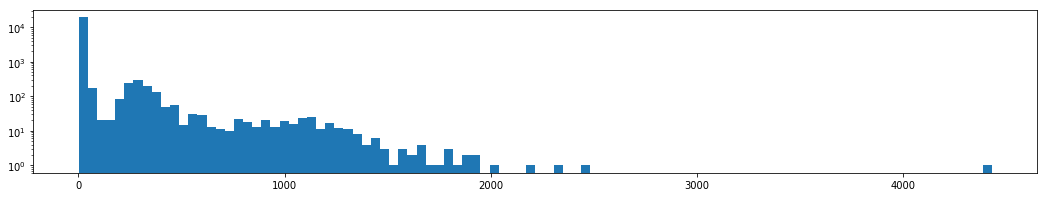

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(18, 3))
plt.hist(df
#          [df['words_count']< 500]
         ['words_count']
         , bins=100, log=True)
# plt.
plt.show()

In [5]:
df[ (df['clean_text']!= 'img')
   & (df['clean_text']!= 'http')
  
  ].sort_values(['words_count']).head()

,link,title,publication_date,content,date,site,section,clean_text,words_count
1837,https://www.reddit.com/r/icocrypto/comments/8h...,ANYTHINGAPPMONEYBOT,1.525573e+09,anythingappmoneybot,1.525573e+09,www.reddit.com,icocrypto,anythingappmoneybot,1
4873,https://www.reddit.com/r/CryptoCurrency/commen...,Coincidence?,1.520531e+09,coincidence?,1.520536e+09,www.reddit.com,CryptoCurrency,coincidence,1
16080,https://www.reddit.com/r/NEO/comments/8fv2gv/f...,Flatuance...,1.525043e+09,flatuance...,1.525043e+09,www.reddit.com,NEO,flatuance,1
18157,https://www.reddit.com/r/ethtrader/comments/8i...,Etheraptor,1.525875e+09,etheraptor,1.525875e+09,www.reddit.com,ethtrader,etheraptor,1
4560,https://www.reddit.com/r/CryptoCurrency/commen...,Beeeeeeeconeeeeeec,1.520377e+09,beeeeeeeconeeeeeec,1.520381e+09,www.reddit.com,CryptoCurrency,beeeeeeeconeeeeeec,1


In [7]:
# df['sender_is_bot'].value_counts()

In [9]:
# df = df[~df['sender_is_bot']].copy()

## find same texts

In [10]:
text_counter = Counter(df['clean_text'])
text_counter.most_common(15)

[('img', 2843),
 ('http', 430),
 ('200 giveaway 1000 eopt for free worth 0 20 per token', 56),
 ('guys don t miss out on these 4 huge airdrops 250 total worth cheers', 31),
 ('list of today s and tomorrow s upcoming events', 26),
 ('200 airdrop 1000 eopt for free worth 0 20 per token', 20),
 ('guys don t miss out on these 5 huge airdrops 250 total worth cheers', 9),
 ('simmitri sim airdrop one of the best airdrops is stirring up the community with this energy efficiency token',
  7),
 ('help make cryptocurrency an academic topic', 6),
 ('this blockchain startup is fighting censorship and why you should join the fight',
  5),
 ('the sunday chart eth price v new daily wallets', 5),
 ('guys don t miss out on these 5 huge airdrops up to 300 total value cheers',
  5),
 ('lightning nfc the new plan to bring bitcoin to retail', 4),
 ('my name is theo chino and i have been standing up to the new york regulators since 2015',
  4),
 ('awesome 200 giveaway 1000 eopt for free worth 0 20 per token'

In [11]:
len_text_min = 0
len_text_max = 1000

text_counter = Counter(df[df['words_count'] > len_text_min]['clean_text'])
text_counter.most_common(10)

[('img', 2843),
 ('http', 430),
 ('200 giveaway 1000 eopt for free worth 0 20 per token', 56),
 ('guys don t miss out on these 4 huge airdrops 250 total worth cheers', 31),
 ('list of today s and tomorrow s upcoming events', 26),
 ('200 airdrop 1000 eopt for free worth 0 20 per token', 20),
 ('guys don t miss out on these 5 huge airdrops 250 total worth cheers', 9),
 ('simmitri sim airdrop one of the best airdrops is stirring up the community with this energy efficiency token',
  7),
 ('help make cryptocurrency an academic topic', 6),
 ('this blockchain startup is fighting censorship and why you should join the fight',
  5)]

In [12]:
print('df.shape with dublicates ', df.shape)
df = df[ (df['words_count'] > 1) & (df['words_count'] < 430)].copy()
print('df.shape without dublicates ', df.shape)

df.shape with dublicates  (21160, 9)
df.shape without dublicates  (17445, 9)


In [13]:
text_counter = Counter(df['clean_text'])

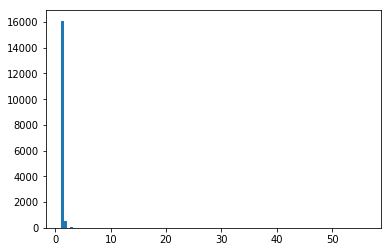

In [14]:
plt.hist(text_counter.values(), bins=100)
plt.show()

In [15]:
df['repeats'] = df['clean_text'].apply(lambda x: text_counter[x])

In [16]:
df = df[df['repeats'] == 1].copy()

In [17]:
RE_DIGIT = re.compile(r'\d')
def has_digit(text):
    return len(RE_DIGIT.findall(text)) > 0

In [18]:
df['has_digit'] = df['clean_text'].apply(has_digit)
df = df[~df['has_digit']].copy()

In [19]:
df.to_csv(os.path.join(path_data, 'clean_{0}.csv'.format(data_type)), index=False)

# learn fasttext representations and to vectors

In [20]:
class SentenceIterator(object):
    texts = None

    def __init__(self, texts):
        self.texts = texts

    def __iter__(self):
        for text in self.texts:
            yield text_to_word_sequence(text, lower=False)

def text2vec(text, vector_size):
    vectors = []
    for word in text_to_word_sequence(text):
        try:
            v = fasttext_model.wv[word]
            vectors.append(v)
        except Exception as e:
            pass
    if not vectors:
        return np.zeros((vector_size, ))
    return sum(vectors) / len(vectors)            

In [27]:
vector_size = 100

for vector_size in [100, 80, 160]: 
    fasttext_model = FastText(SentenceIterator(df['clean_text']), min_count=5, size=vector_size, workers=-1)
    fasttext_model.save(os.path.join(path_data, 'fasttext_{0}_{1}.bin'.format(data_type, vector_size)))
#     print(fasttext_model.wv.most_similar('btc'))
#     print(fasttext_model.wv.most_similar('eth'))
    vectors = list(map(functools.partial(text2vec, vector_size=vector_size), df['clean_text'] ))
    vectors = np.array(vectors)
    np.save(os.path.join(path_data, '{0}_vectors_{1}.npy'.format(data_type, vector_size)) , vectors)

In [23]:
df[df['clean_text'].str.contains('ethusd')].head(3)

,link,title,publication_date,content,date,site,section,clean_text,words_count,repeats,has_digit


# to vectors